# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload
import sklearn.preprocessing as pre


pd.options.display.float_format = '{:,.6f}'.format

#set font size
sns.set(font_scale=1.5)
#set graph style
sns.set_style('white')

#import my personal modules created for this report
import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents an instance of an online advertisement
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Created columns ```hour_of_day``` and ```day_of_week``` based on ```hour``` column
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [4]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**id**| Advertisement instance unique id | *int*|
| **hour** | The date and hour of day |*datetime*|
| **C1** | Anonymized categorical variable |*int*|
|**banner_pos**| Location of ad on the page | *int*|
|**hour_of_day**| Hour of the day when the ad was displayed | *str*|
|**day_of_week**| Day of the week when the ad was displayed | *str*|
|**C14-C21**|Anonymized continuous variables | *int*|
|**Target variable**
|**click**| Did they click? (1-Yes, 0-No) | *int* |

### A look at the data

In [5]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
366134,2009636145773373157,0,2014-10-27 16:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15701,320,50,1722,0,35,-1,79,16,Monday
95054,17172250707259950008,0,2014-10-24 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,21762,320,50,2502,0,39,-1,221,6,Friday
189299,2922056073063093914,0,2014-10-25 13:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,15706,320,50,1722,0,35,100083,79,13,Saturday
569650,4743847194723927815,0,2014-10-29 14:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,23822,320,50,2728,0,290,-1,42,14,Wednesday
581283,218700043766238420,1,2014-10-29 17:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,17614,320,50,1993,2,1063,100084,33,17,Wednesday


## Explore

### 1. What percentage of visits resulted in a click-through?

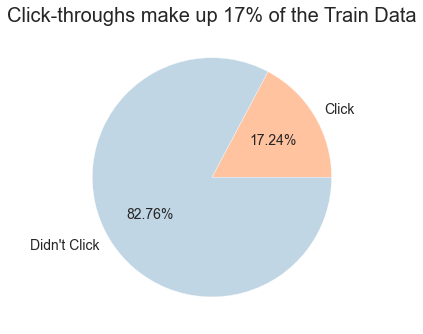

In [6]:
#show percentage of clicks
e.click_percentage(train)

### 2. Does the hour of the day have an impact of click-throughs?

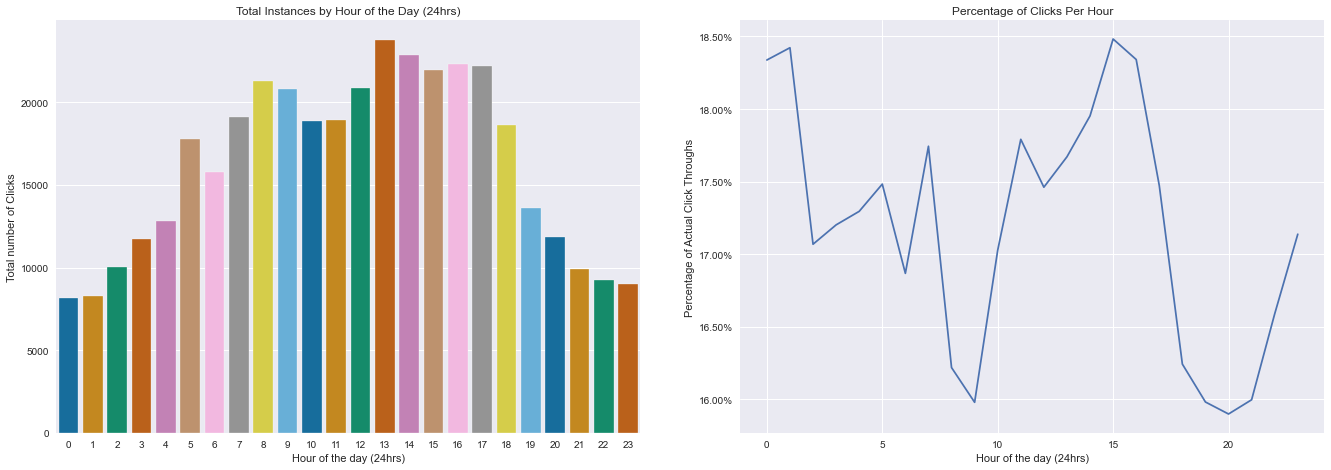

In [7]:
e.hour_click_through_viz(train)

**It looks like there are more click throughs per instance at 1 am and 3 pm (15).** 

***Let's do a $\chi^2$ to see if there is a relationship***

**Set Hypothesis**

$H_0$ = There is no relationship between each ```hour_of_day``` and ```click```.

$H_a$ = There is a relationship between each ```hour_of_day``` and ```click```.

In [8]:
pd.set_option("display.max_columns", 50)

In [9]:
e.chi_square_matrix(train, 'hour_of_day', 'click').T

hour_of_day,15,9,16,8,19,20,18,21,14,1,0,11,7,13,22,6,17,5,12,10,2,23,4,3
χ^2,24.974033,24.494476,19.948293,16.443461,15.645811,15.374762,13.647408,10.994026,8.531434,8.129003,6.936594,4.153922,3.490100,3.218827,2.792559,1.592921,0.855082,0.733638,0.722513,0.628886,0.206261,0.064111,0.021792,0.011356
p-value,0.000001,0.000001,0.000008,0.000050,0.000076,0.000088,0.000221,0.000914,0.003491,0.004356,0.008445,0.041538,0.061737,0.072796,0.094703,0.206909,0.355119,0.391707,0.395321,0.427764,0.649714,0.800112,0.882641,0.915134


**p < alpha for ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) so we can reject the null hypothesis for those hours and say there is probably a relationship between those hours and ```clicks```**

## 3. Does the day of the week have an impact on click-throughs?

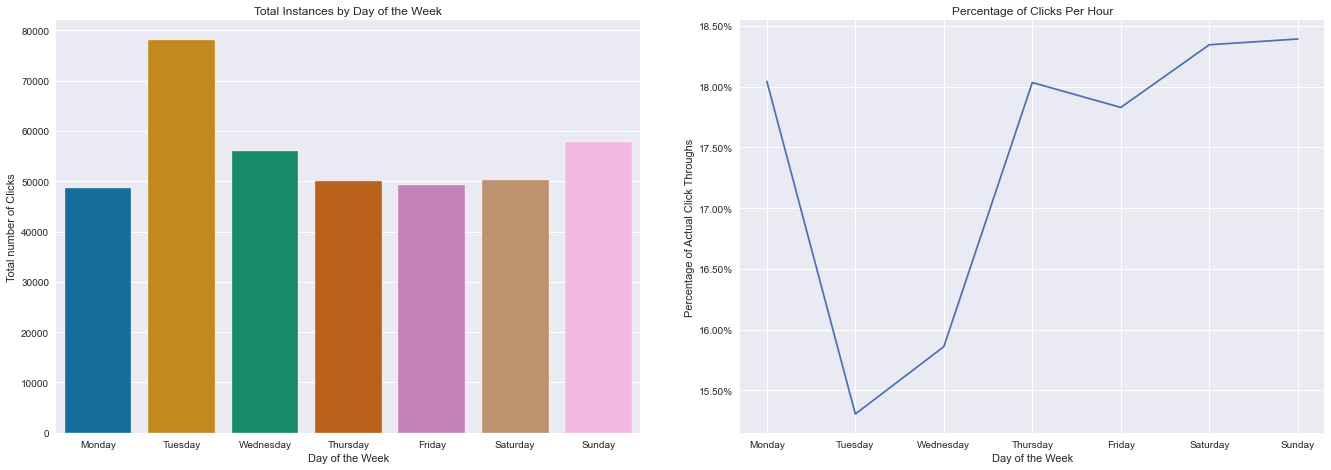

In [10]:
e.day_click_through_viz(train)

**Set Hypothesis**

$H_0$ = There is no relationship between each ```day_of_week``` and ```click```.

$H_a$ = There is a relationship between each ```day_of_week``` and ```click```.

In [11]:
e.chi_square_matrix(train, 'day_of_week', 'click')

,χ^2,p-value
day_of_week,,
Tuesday,256.610032,0.000000
Wednesday,87.576922,0.000000
Sunday,62.540524,0.000000
Saturday,48.801849,0.000000
Thursday,25.087336,0.000001
Monday,24.819706,0.000001
Friday,13.459815,0.000244


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between every ```day_of_week``` and ```click```.** 

## 4. Does banner position have an impact click-throughs?

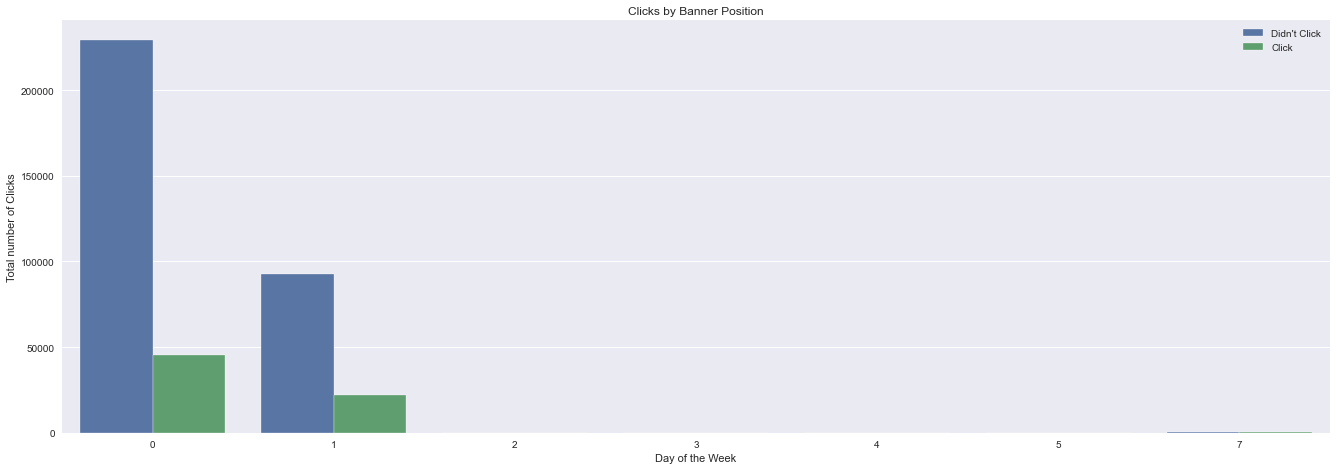

In [12]:
e.banner_pos_viz(train)

**Set Hypothesis**

$H_0$ = There is no association between each ```banner_pos``` and ```click```.

$H_a$ = There is a association between each ```banner_pos``` and ```click```.

In [13]:
e.chi_square_matrix(train, 'banner_pos', 'click').T

banner_pos,0,1,7,2,3,5,4
χ^2,419.231320,397.382334,72.117357,8.486756,0.342021,0.184251,0.036154
p-value,0.000000,0.000000,0.000000,0.003577,0.558665,0.667745,0.849197


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```banner_pos``` (0, 1, 2, 7) and ```click```.** 

## 5. Do the annoymized continuous features have an impact on click-throughs?

**Set Hypothesis**

$H_0$ = There is no difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

$H_a$ = There is a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

After running levene test, each feature was found of equal variance.

In [14]:
e.continuous_vars_ttest(train).T

Feature,C14,C15,C16,C17,C18,C19,C20,C21
t-stat,-32.637333,-24.622133,88.747292,-28.859901,23.310517,-7.521031,-37.508760,-47.752094
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**p < alpha, so we can reject the null hypothesis and say there is proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.** 

### Exploration Summary
* ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) probably have a relationship with```clicks```.
* Each ```day_of_week``` probably has a relationship with ```click```.
* ```banner_pos``` (0, 1, 2, 7) probably have a relationship with ```click```.
* Proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**hour_of_day_(0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21)**| $\chi^2$ test results|
|**day_of_week_(Monday-Sunday)**| $\chi^2$ test results|
|**banner_pos_(0, 1, 2, 7)**| $\chi^2$ test results|
|**C14-C21**| t-test results|

### Features I'm not moving on with

* All other columns will be dropped because it was difficult to find relationship with the other categorical variables and ```click``` due to computing power.

### Prep for modeling
* Scale the numeric variables using the minmax scaler
* Encode categorical variables

In [15]:
cols_to_encode = ['banner_pos', 'hour_of_day', 'day_of_week']

In [16]:
train, validate, test = m.pre_prep(train, validate, test, cols_to_encode, 'click')

In [17]:
drivers = ['hour_of_day_0','hour_of_day_1','hour_of_day_8','hour_of_day_9',
           'hour_of_day_11','hour_of_day_14','hour_of_day_15','hour_of_day_16',
           'hour_of_day_18','hour_of_day_19','hour_of_day_20','hour_of_day_21', 
           'banner_pos_0', 'banner_pos_1', 'banner_pos_2', 'banner_pos_7',
           'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [18]:
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'click', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [19]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 82.76%


### Model Comparison

In [ ]:
m.compare_models(X_train, y_train, X_validate, y_validate)

In [21]:
########### DECICSION TREE HYPERPARAMETER TESTING####################

metric = []
# compare in-sample to out-of-sample

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=27)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df["accuracy_diff"] = df.train_accuracy - df.validate_accuracy
df.sort_values(by=['train_accuracy' ,'accuracy_diff']).set_index('max_depth')

,train_accuracy,validate_accuracy,accuracy_diff
max_depth,,,
1,0.827571,0.827568,0.000003
2,0.827571,0.827568,0.000003
3,0.827571,0.827568,0.000003
4,0.828441,0.828343,0.000097
5,0.828789,0.828635,0.000155
6,0.829246,0.829160,0.000086
7,0.829525,0.829001,0.000524
8,0.829661,0.828901,0.000760
9,0.830248,0.829293,0.000955


In [33]:
########### RANDOM FORREST HYPERPARAMETER TESTING####################

metric = []
# compare in-sample to out-of-sample

for l in range(1,15):
    # Make the model
    rf = RandomForestClassifier(max_depth=10, min_samples_leaf = l, random_state=27)

    # Fit the model (on train and only train)
    rf.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = rf.score(X_train, y_train)
    out_of_sample_accuracy = rf.score(X_validate, y_validate)

    output = {
        "max_depth": 10,
        "min_samples_leaf": l,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }

    metric.append(output)

df = pd.DataFrame(metric)
df["accuracy_diff"] = df.train_accuracy - df.validate_accuracy

df.sort_values(by=['accuracy_diff','train_accuracy'], ascending=[False, True])

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,accuracy_diff
0,10,1,0.830448,0.829893,0.000555
2,10,3,0.830379,0.829660,0.000719
1,10,2,0.830376,0.829668,0.000708
3,10,4,0.830220,0.829476,0.000744
5,10,6,0.830192,0.829801,0.000390
4,10,5,0.830182,0.829718,0.000464
10,10,11,0.830123,0.829801,0.000321
8,10,9,0.830102,0.829668,0.000434
12,10,13,0.830061,0.829651,0.000410
7,10,8,0.830056,0.829618,0.000438


In [28]:
pd.set_option("display.max_rows", 200)

In [34]:
########### KNN HYPERPARAMETER TESTING####################

metric = []
# compare in-sample to out-of-sample

for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)

    #fit model on training data
    knn.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = knn.score(X_train, y_train)
    out_of_sample_accuracy = knn.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }

    metric.append(output)
    
df = pd.DataFrame(metric)
df["accuracy_diff"] = df.train_accuracy - df.validate_accuracy

KeyboardInterrupt: 

In [32]:
m.log_results(X_train, y_train, X_validate, y_validate)

Logistic Regression
Train Accuracy: 82.66%
Validate Accuracy: 82.64%
Difference: 0.02%


### Models Summary
* All models except for logistic regression perfomed better than baseline for both train and validate data.
* With running hyperparameter tests there was very little improvement.

### Best model: Random Forest Model 
* I chose the Random Forest Model because it beat baseline on both train and validate, and the difference between train accuracy and validate accuracy was the smallest.
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion
### Summary
* ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) probably have a relationship with```clicks```.
* Each ```day_of_week``` probably has a relationship with ```click```.
* ```banner_pos``` (0, 1, 2, 7) probably have a relationship with ```click```.
* Proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

### Recommendations
* We need to invest in some cloud computing in order to run statisical tests and models on such large data sets.
* Even though my best model only performs 0.34% better than baseline, we can use it for now as we continue to improve our model.

### Next Steps
* In the next iteration:
    * Use cloud computing to look more into all the different features.
    * Try hashing some of the features to see if that will improve my models.